In [1]:
from math import *
import numpy as np
import matplotlib.pyplot as plt

from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

import matplotlib.pyplot as plt
import mlai.plot as plot

In [2]:
# Simulation presettings
write_images = False
wirte_output_txt = False
%run Missile_utils.ipynb
simulation_output = 'range'

In [3]:
custom_param_names = ['fuelmass']

In [4]:

# Low-fidelity simulator class
class simple_simulator_mod:
    def __init__(self,fuelmass,drymass,payload,missilediam,params=True):
        self.dMdt = 500
        self.v_ex = 5000
        
        if params is None:
            self.drymass = 0.8e6
            self.fuelmass = 2e6
            self.diam = 1.65
            
        else:
            self.drymass = drymass + payload
            self.fuelmass = fuelmass
            self.diam = missilediam
    
    def get_range(self):
        h=1e-5
        v=1e-5
        gamma = self.to_radians(90)
        thrust = self.v_ex * self.dMdt
        mass = self.drymass + self.fuelmass
        area = pi*(self.diam**2)/4
        G = 6.6743e-11
        M = 5.972e24
        R = 6.371e6
        g = G*M/(R**2)
        dm = self.dMdt
        t=0
        psi=0
        dt=1e-1
        tEND=1e8
        heights = []
        velocity = []
        gammas = []
        cnt=0
        while(h>0):
            if t>tEND:
                break
            try:
                dv = thrust/mass - g*sin(gamma)
            except:
                dv = 0
            dpsi = v*cos(gamma)/(R+h)
            dh = v*sin(gamma)
            if t<5:
                dgamma = -0.1
            else:
                dgamma = dpsi - g*cos(gamma)/v
#                 print(dgamma)
                
            if mass <= self.drymass:
                thrust=0
                mass = self.drymass
                dm=0
#                 if cnt==0:
#                     print("THRUST HAS BEEN PUT TO ZERO")
#                     cnt+=1
            else:
                mass = mass - dm*dt
    
            v = v + dt*dv
#             print(dh)
            h = h + dt*dh
            heights.append(h)

            gamma = gamma + dt*dgamma
            gammas.append(gamma)
            psi = psi + dt*dpsi
            g =  G*M/((R+h)**2)
            t= t+dt
            velocity.append(v)
            
#         plt.plot(velocity)
#         plt.show()
        #plt.plot(gammas)
        #plt.show()
        if psi<0:
            print("Rocket Failed (PSI)")
            return 0
        if t>tEND:
            print("Rocket Failed (tend)")
            return 0
        return psi*R/1000
        
        
    def eta(self,h,t):
        eta = 0.0
        return eta      
    
    def density(self,h):
        "Calculates air density at altitude"    
        rho0 = 1.225 #[kg/m^3] air density at sea level
        if h < 19200:
            rho = rho0 * exp(-h/8420)
        elif h > 19200 and h < 47000:
            rho = rho0 * (.857003 + h/57947)**-13.201
        else:
            #vacuum
            rho = 0.0
        return rho
        
    def temperature(self,h):
        "Calculates air temperature [Celsius] at altitude [m]"
        if h <= 11000:
            #troposphere
            t = 15.04 - .00649*h
        elif h <= 25000:
            #lower stratosphere
            t = -56.46
        elif h > 25000:
            t = -131.21 + .00299*h
        return t
    
    def pressure(self,h):
        "Calculates air pressure [Pa] at altitude [m]"  
        t = self.temperature(h)      
        if h <= 11000:
            #troposphere
            p = 101.29 * ((t+273.1)/288.08)**5.256
        elif h <= 25000:
            #lower stratosphere
            p = 22.65*exp(1.73-.000157*h)
        elif h > 25000:
            p = 2.488 * ((t+273.1)/288.08)**-11.388
        return p
        
    def Cdrag (self,v,h):
        t = self.temperature(h) + 273.15 #convert to kelvin
        a = sqrt(1.4*287*t) 
        mach = v/a
        
        if mach > 5:
            cd = 0.15
        elif mach > 1.8 and mach <= 5:
            cd = -0.03125*mach + 0.30625
        elif mach > 1.2 and mach <= 1.8:
            cd = -0.25*mach + 0.7
        elif mach > 0.8 and mach <= 1.2:
            cd = 0.625*mach - 0.35
        elif mach <= 0.8:
            cd = 0.15
        return cd
        
    def to_radians(self,degree):
        return degree * pi/180

In [5]:
# Low-fidelity simulation helper
def run_missile_low_sim(custom_params):
    """    
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'fuelmass':5600,
        'drymass':1200,
        'Isp0':226,
        'thrust0':9177.4
    }
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        # Row: different parameters -> different runs from the simulator
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            # For each custom variable
            param_name = custom_param_names[j]
            params_to_use[param_name] = custom_params[i,j]
        
            ## TEMP ## Better customise this
            #if j==0:
            #    print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            #print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_obj = simple_simulator_mod( 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"],
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],
        )
        Tm = 1.4e4*2000 / (params_to_use["fuelmass"]+params_to_use["drymass"])
        g = 6.6743e-11*5.972e24/(6.371e6**2)
        if Tm < g:
            print("Tm<g -> will fail")
        print(f'Fuel {params_to_use["fuelmass"]}, dry {params_to_use["drymass"]}')
        
        y[i, 0] = sim_obj.get_range()
    return y


In [6]:
# High-fidelity simulator helper
def run_missile_high_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }   
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
        
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y


# Actual analysis-code starting; fuelmass

In [7]:
basic_param_spaces = {
    'payload':  [10, 2410],
    'missilediam':  [0.1, 9.9],
    'rvdiam':  [0.1, 9.9],
    'estrange': [100, 4900], 
    'fuelmass': [500, 6000], # [500, 7000], 
    'drymass':  [1000, 3000],
    'Isp0':  [100, 800],# [100, 800],
    'thrust0':  [10000, 69000],
}

In [8]:
high_f = run_missile_high_sim
low_f = run_missile_low_sim

x_dry = np.linspace(1200, 3000,101)[:, np.newaxis]
x_fuel = np.linspace(500, 6000, 101)[:, np.newaxis]
xt = np.array([x_fuel, x_dry]).reshape(101, 2)


x_plot = x_fuel
y_plot_low = low_f(x_fuel)
print(y_plot_low)


Fuel 500.0, dry 1200
Fuel 555.0, dry 1200
Fuel 610.0, dry 1200
Fuel 665.0, dry 1200
Fuel 720.0, dry 1200
Fuel 775.0, dry 1200
Fuel 830.0, dry 1200
Fuel 885.0, dry 1200
Fuel 940.0, dry 1200
Fuel 995.0, dry 1200
Fuel 1050.0, dry 1200
Fuel 1105.0, dry 1200
Fuel 1160.0, dry 1200
Fuel 1215.0, dry 1200
Fuel 1270.0, dry 1200
Fuel 1325.0, dry 1200
Fuel 1380.0, dry 1200
Fuel 1435.0, dry 1200
Fuel 1490.0, dry 1200
Fuel 1545.0, dry 1200
Fuel 1600.0, dry 1200
Fuel 1655.0, dry 1200
Fuel 1710.0, dry 1200
Fuel 1765.0, dry 1200
Fuel 1820.0, dry 1200
Fuel 1875.0, dry 1200
Fuel 1930.0, dry 1200
Fuel 1985.0, dry 1200
Fuel 2040.0, dry 1200
Fuel 2095.0, dry 1200
Fuel 2150.0, dry 1200
Fuel 2205.0, dry 1200
Fuel 2260.0, dry 1200
Fuel 2315.0, dry 1200
Fuel 2370.0, dry 1200
Fuel 2425.0, dry 1200
Fuel 2480.0, dry 1200
Fuel 2535.0, dry 1200
Fuel 2590.0, dry 1200
Fuel 2645.0, dry 1200
Fuel 2700.0, dry 1200
Fuel 2755.0, dry 1200
Fuel 2810.0, dry 1200
Fuel 2865.0, dry 1200
Fuel 2920.0, dry 1200
Fuel 2975.0, dry 120

In [9]:
y_plot_high = high_f(x_dry)


New simulation 

fuelmass: 1200.0


Stage 1 burnout
Velocity (km/s):  0.7908505312667907
Angle (deg h):  43.69594854229949
Range (km):  5.035098011499057
Time (sec):  29.600000000000154
Final results: 
Range (km):  77.75315473586167
Apogee (km):  24.656822214792744
Time to target (sec):  157.29999999999535



New simulation 

fuelmass: 1218.0


Stage 1 burnout
Velocity (km/s):  0.7975563869545823
Angle (deg h):  43.774980156766496
Range (km):  5.138631623699392
Time (sec):  30.00000000000016
Final results: 
Range (km):  79.11601222052748
Apogee (km):  25.154470640505213
Time to target (sec):  158.99999999999525



New simulation 

fuelmass: 1236.0


Stage 1 burnout
Velocity (km/s):  0.8078770589386342
Angle (deg h):  43.66913302855969
Range (km):  5.300981267978743
Time (sec):  30.500000000000167
Final results: 
Range (km):  81.23366944422717
Apogee (km):  25.7498172386175
Time to target (sec):  160.99999999999514



New simulation 

fuelmass: 1254.0


Stage 1 burnout
Velocity (km/s):

Final results: 
Range (km):  134.70012866679804
Apogee (km):  42.848698776815006
Time to target (sec):  212.09999999999224



New simulation 

fuelmass: 1776.0


Stage 1 burnout
Velocity (km/s):  1.0443756323531224
Angle (deg h):  43.65486384700415
Range (km):  9.590530288569408
Time (sec):  43.80000000000035
Final results: 
Range (km):  137.3422289402364
Apogee (km):  43.57923235054061
Time to target (sec):  214.09999999999212



New simulation 

fuelmass: 1794.0


Stage 1 burnout
Velocity (km/s):  1.0501605560335294
Angle (deg h):  43.705820266038295
Range (km):  9.712261135740494
Time (sec):  44.20000000000036
Final results: 
Range (km):  138.8790998423369
Apogee (km):  44.146782656926064
Time to target (sec):  215.59999999999204



New simulation 

fuelmass: 1812.0


Stage 1 burnout
Velocity (km/s):  1.0599589918538064
Angle (deg h):  43.638735117532576
Range (km):  9.910626778297992
Time (sec):  44.700000000000365
Final results: 
Range (km):  141.55493316603844
Apogee (km):  44.88

Stage 1 burnout
Velocity (km/s):  1.2627055025906828
Angle (deg h):  43.64912901625669
Range (km):  14.474000147367724
Time (sec):  57.10000000000054
Final results: 
Range (km):  201.96239615152854
Apogee (km):  63.895401835630395
Time to target (sec):  264.49999999999164



New simulation 

fuelmass: 2334.0


Stage 1 burnout
Velocity (km/s):  1.2677595137818816
Angle (deg h):  43.68724407794253
Range (km):  14.604634391555587
Time (sec):  57.50000000000055
Final results: 
Range (km):  203.70378382275675
Apogee (km):  64.49861805679222
Time to target (sec):  265.999999999992



New simulation 

fuelmass: 2352.0


Stage 1 burnout
Velocity (km/s):  1.2727808096672273
Angle (deg h):  43.668035563734065
Range (km):  14.735338896578297
Time (sec):  57.90000000000055
Final results: 
Range (km):  205.35670190644322
Apogee (km):  65.01764133914497
Time to target (sec):  267.19999999999226



New simulation 

fuelmass: 2370.0


Stage 1 burnout
Velocity (km/s):  1.2822449957206012
Angle (deg h):

Stage 1 burnout
Velocity (km/s):  1.4492078929620544
Angle (deg h):  43.68662422330499
Range (km):  19.47604494995609
Time (sec):  69.9000000000003
Final results: 
Range (km):  267.5729507358237
Apogee (km):  84.51505111132559
Time to target (sec):  310.000000000002



New simulation 

fuelmass: 2856.0


Stage 1 burnout
Velocity (km/s):  1.4578403582469257
Angle (deg h):  43.64610166787425
Range (km):  19.71289129196687
Time (sec):  70.40000000000028
Final results: 
Range (km):  270.77001253908736
Apogee (km):  85.4078145012458
Time to target (sec):  311.8000000000024



New simulation 

fuelmass: 2874.0


Stage 1 burnout
Velocity (km/s):  1.4617654807586615
Angle (deg h):  43.676531663510886
Range (km):  19.844973570209454
Time (sec):  70.80000000000025
Final results: 
Range (km):  272.2595142935236
Apogee (km):  85.98331074453361
Time to target (sec):  313.0000000000027



New simulation 

fuelmass: 2892.0


Stage 1 burnout
Velocity (km/s):  1.4656540047643345
Angle (deg h):  43.6630

In [10]:
x_train_low = np.random.rand(12)[:, np.newaxis]
x_train_high = np.random.permutation(x_train_low)[:6]

y_train_low = low_f(x_train_low)
y_train_high = high_f(x_train_high)
print(y_train_low)

Fuel 0.8950948638903765, dry 1200
Fuel 0.4526505807030744, dry 1200
Fuel 0.9084196796343504, dry 1200
Fuel 0.5979965514858023, dry 1200
Fuel 0.19580206573237335, dry 1200
Fuel 0.16573172670458058, dry 1200
Fuel 0.36737955448279336, dry 1200
Fuel 0.715852451258614, dry 1200
Fuel 0.4509029017433712, dry 1200
Fuel 0.217207320447102, dry 1200
Fuel 0.07165168807526567, dry 1200
Fuel 0.4870035563682915, dry 1200

New simulation 

fuelmass: 0.5979965514858023


Stage 1 burnout
Velocity (km/s):  0.0008671645645113179
Angle (deg h):  90.0
Range (km):  5.309074240817777e-22
Time (sec):  0.02
Final results: 
Range (km):  -2.1905775575274905e-22
Apogee (km):  4.799845735567568e-05
Time to target (sec):  0.21000000000000005



New simulation 

fuelmass: 0.4509029017433712


Stage 1 burnout
Velocity (km/s):  0.0004335648118274344
Angle (deg h):  90.0
Range (km):  1.3272150502295263e-22
Time (sec):  0.01
Final results: 
Range (km):  -2.1486501661353615e-22
Apogee (km):  1.2664819154467962e-05
Time to

In [11]:
X_train, Y_train = convert_xy_lists_to_arrays([x_train_low, x_train_high], 
                                                    [y_train_low, y_train_high])

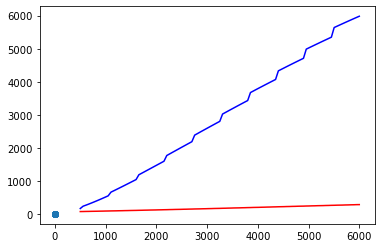

In [12]:
plt.figure()
plt.plot(x_plot, y_plot_low, 'b')
plt.plot(x_plot, y_plot_high, 'r')

plt.scatter(x_train_low, y_train_low)

In [13]:
y_train_low

array([[6.40313695],
       [6.40516557],
       [6.40307587],
       [6.40449903],
       [6.41843405],
       [6.41857227],
       [6.40555666],
       [6.40395865],
       [6.40517358],
       [6.40624551],
       [6.41900473],
       [6.40500802]])